# importing stuff

In [3]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# declaring variables

In [4]:
ticker = 'TSLA'
ema_span = 7
trnd_cnfrm_b = 1
trnd_cnfrm_s = 1
stop_loss = 0.03
a1 = yf.Ticker(ticker)
df = a1.history(period = "60d", interval = '5m')

long_position = False
short_position = False

# Creating df columns for the strat and plotting

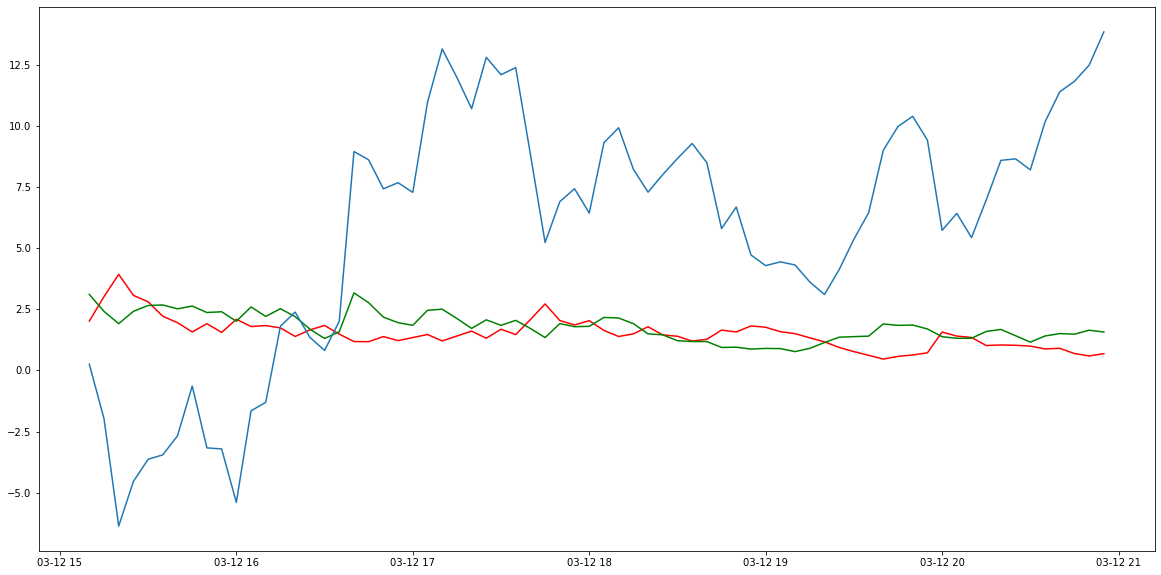

In [5]:
df['buying_press'] = df.Close - df.Low
df['selling_press'] = df.High - df.Close
df['sp_ema'] = df.selling_press.ewm(span = ema_span).mean()
df['bp_ema'] = df.buying_press.ewm(span = ema_span).mean()

plt.plot(df.sp_ema[-70:], color = 'red')
plt.plot(df.bp_ema[-70:], color = 'green')
plt.plot(df.Close[-70:]-680)
plt.show()

# creating an Account class and myAccount Object

In [6]:
class Account:
    def __init__(self, cash_bal):
        self.cash_bal = cash_bal
        self.selling = []
        self.buying = []
        self.worth_arr = []
        self.long_pos = 0
        self.short_pos = 0
    
    last_price = 0
    
    def buy(self, price, volume, time, pos):
            self.cash_bal -= price*volume
            self.buying.append([price, volume, time])
            last_price = price
            if (pos == 'long'):
                self.long_pos += volume
                self.updateWorth(self.cash_bal, self.long_pos*volume, self.short_pos*volume, time)
            if (pos == 'short'):
                self.short_pos -= volume
                self.updateWorth(self.cash_bal, self.long_pos*volume, self.short_pos*volume, time)
                
    def sell(self, price, volume, time, pos):
            self.cash_bal += price*volume
            self.selling.append([price, volume, time])
            last_price = price
            if (pos == 'long'):
                self.long_pos -= volume
                self.updateWorth(self.cash_bal, self.long_pos*volume, self.short_pos*volume, time)
            if (pos == 'short'):
                self.short_pos += volume
                self.updateWorth(self.cash_bal, self.long_pos*volume, self.short_pos*volume, time)
    
    def updateWorth(self, c_bal, long, short, time):
            worth = c_bal + long - short
            self.worth_arr.append([worth, time])
    
myAccount = Account(10000)

# the backtest

In [14]:
for i in range(ema_span, len(df)):
    if ((df.index[i].time() >= dt.time(9,30)) & (df.index[i].time() < dt.time(15,0))):
        # buying long
        if((df.bp_ema[i] > trnd_cnfrm_b*df.sp_ema[i]) & (long_position == False)):
            long_position = True
            volume = round(myAccount.cash_bal/df.Close[i], 0)
            myAccount.buy(df.Close[i], volume, df.index[i], 'long')
            print('long position taken @{} and @{}'.format(df.index[i], df.Close[i]))
        
        # selling long
        if((df.sp_ema[i] > trnd_cnfrm_s*df.bp_ema[i]) & (long_position == True)):
            long_position = False
            volume = myAccount.long_pos
            myAccount.sell(df.Close[i], volume, df.index[i], 'long')
            print('long position exited @{} and @{}'.format(df.index[i], df.Close[i]))
            #stoploss long
            #if((myAccount.last_price != None) & (df.Close[i] < (1-stop_loss)*myAccount.last_price) & (long_position == True)):
            #   long_position = False
            #    volume = myAccount.long_pos
            #    myAccount.sell(df.Close[i], volume, df.index[i], 'long')
            #    print('long position exited @{} and @{}'.format(df.index[i], df.Close[i]))
            
        
        # selling short
        if((df.sp_ema[i] > trnd_cnfrm_s*df.bp_ema[i]) & (long_position == False)):
            long_position = True
            volume = round(myAccount.cash_bal/df.Close[i], 0)
            myAccount.sell(df.Close[i], volume, df.index[i], 'short')
            print('short position taken @{} and @{}'.format(df.index[i], df.Close[i]))
        
        # buying short
        if((df.bp_ema[i] > trnd_cnfrm_b*df.sp_ema[i]) & (short_position == True)):
            short_position = False
            volume = myAccount.short_pos
            myAccount.buy(df.Close[i], volume, df.index[i], 'short')
            print('short position exited @{} and @{}'.format(df.index[i], df.Close[i]))

            #stoploss short
            #if((myAccount.last_price != None)&(df.Close[i] > (1+stop_loss)*myAccount.last_price) & (short_position == True)):
            #    long_position = False
            #    volume = myAccount.short_pos
            #    myAccount.sell(df.Close[i], volume, df.index[i], 'short')
            #    print('short position exited @{} and @{}'.format(df.index[i], df.Close[i]))
       
        

long position exited @2020-12-15 10:35:00-05:00 and @642.5792846679688
short position taken @2020-12-15 10:35:00-05:00 and @642.5792846679688
long position exited @2020-12-15 10:40:00-05:00 and @643.6799926757812
short position taken @2020-12-15 10:40:00-05:00 and @643.6799926757812
long position exited @2020-12-15 10:45:00-05:00 and @642.1286010742188
short position taken @2020-12-15 10:45:00-05:00 and @642.1286010742188
long position exited @2020-12-15 10:55:00-05:00 and @639.2200927734375
short position taken @2020-12-15 10:55:00-05:00 and @639.2200927734375
long position exited @2020-12-15 11:00:00-05:00 and @631.5291137695312
short position taken @2020-12-15 11:00:00-05:00 and @631.5291137695312
long position exited @2020-12-15 11:05:00-05:00 and @631.4799194335938
short position taken @2020-12-15 11:05:00-05:00 and @631.4799194335938
long position exited @2020-12-15 11:25:00-05:00 and @627.0845947265625
short position taken @2020-12-15 11:25:00-05:00 and @627.0845947265625
long p

In [13]:
myAccount.worth_arr


[[-33.31640625, Timestamp('2020-12-15 10:05:00-0500', tz='America/New_York')],
 [9991.9521484375,
  Timestamp('2020-12-15 10:35:00-0500', tz='America/New_York')],
 [20017.220703125,
  Timestamp('2020-12-15 10:35:00-0500', tz='America/New_York')],
 [20273.220703125,
  Timestamp('2020-12-15 10:40:00-0500', tz='America/New_York')],
 [38770.30047607422,
  Timestamp('2020-12-15 10:40:00-0500', tz='America/New_York')],
 [40227.30047607422,
  Timestamp('2020-12-15 10:45:00-0500', tz='America/New_York')],
 [73751.40234375,
  Timestamp('2020-12-15 10:45:00-0500', tz='America/New_York')],
 [80681.40234375,
  Timestamp('2020-12-15 10:55:00-0500', tz='America/New_York')],
 [131487.13403320312,
  Timestamp('2020-12-15 10:55:00-0500', tz='America/New_York')],
 [161223.13403320312,
  Timestamp('2020-12-15 11:00:00-0500', tz='America/New_York')],
 [197058.0580444336,
  Timestamp('2020-12-15 11:00:00-0500', tz='America/New_York')],
 [322263.0580444336,
  Timestamp('2020-12-15 11:05:00-0500', tz='Americ

3605

OverflowError: cannot convert float infinity to integer

<Figure size 1440x720 with 1 Axes>

In [257]:
ben = []
ben.pop()

IndexError: pop from empty list